# Udacity Machine Learning Engineer Nanodegree Capstone Project

### Upload data to notebook

In [2]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
data_dir = 'C:\\Udacity ML Engineer Nanodegree\\Building ML Portfolio Project\\Images\\natural_images\\'

train_dir = os.path.join(data_dir,'train/')
test_dir = os.path.join(data_dir, 'test/')

classes = ["airplane", "car", "cat", "dog", "flower", "fruit", "motorbike", "person"]

In [19]:
# transform data to 224x224 images
transformed_data = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=transformed_data)
test_data = datasets.ImageFolder(test_dir, transform=transformed_data)

In [20]:
print("Number of images in train dataset: {}".format(len(train_data)))
print("Number of images in test dataset: {}".format(len(test_data)))

Number of images in train dataset: 5527
Number of images in test dataset: 1372


In [21]:
# define dataloaders using batch size of 20
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0, shuffle=True)

### Visualize some of the images

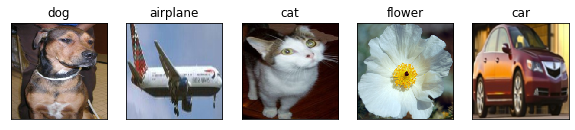

In [22]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize = (10,2))
for pic in np.arange(5):
    ax = fig.add_subplot(1, 5, pic+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[pic], (1,2,0)))
    ax.set_title(classes[labels[pic]])

### Define both models

#### ResNet Model

In [23]:
resnet_50 = models.resnet50(pretrained=True)
print(resnet_50)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\trevo/.cache\torch\checkpoints\resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [25]:
print("Last fully connected layer of ResNet 50 model:")
print(resnet_50.fc)

Last fully connected layer of ResNet 50 model:
Linear(in_features=2048, out_features=1000, bias=True)


In [30]:
# print list of parameters
for layer1, child in resnet_50.named_children():
    for layer2, params in child.named_parameters():
        print(layer1, layer2)

conv1 weight
bn1 weight
bn1 bias
layer1 0.conv1.weight
layer1 0.bn1.weight
layer1 0.bn1.bias
layer1 0.conv2.weight
layer1 0.bn2.weight
layer1 0.bn2.bias
layer1 0.conv3.weight
layer1 0.bn3.weight
layer1 0.bn3.bias
layer1 0.downsample.0.weight
layer1 0.downsample.1.weight
layer1 0.downsample.1.bias
layer1 1.conv1.weight
layer1 1.bn1.weight
layer1 1.bn1.bias
layer1 1.conv2.weight
layer1 1.bn2.weight
layer1 1.bn2.bias
layer1 1.conv3.weight
layer1 1.bn3.weight
layer1 1.bn3.bias
layer1 2.conv1.weight
layer1 2.bn1.weight
layer1 2.bn1.bias
layer1 2.conv2.weight
layer1 2.bn2.weight
layer1 2.bn2.bias
layer1 2.conv3.weight
layer1 2.bn3.weight
layer1 2.bn3.bias
layer2 0.conv1.weight
layer2 0.bn1.weight
layer2 0.bn1.bias
layer2 0.conv2.weight
layer2 0.bn2.weight
layer2 0.bn2.bias
layer2 0.conv3.weight
layer2 0.bn3.weight
layer2 0.bn3.bias
layer2 0.downsample.0.weight
layer2 0.downsample.1.weight
layer2 0.downsample.1.bias
layer2 1.conv1.weight
layer2 1.bn1.weight
layer2 1.bn1.bias
layer2 1.conv2.we

In [31]:
# freeze all layers except last layer
for layer1, child in resnet_50.named_children():
    if layer1 != "fc":
        for _, params in child.named_parameters():
            params.requires_grad = False

In [34]:
import torch.nn as nn

# replace last fully connected layer with our own
n_inputs = resnet_50.fc.in_features

resnet_50.fc = nn.Linear(n_inputs, len(classes))
print(resnet_50.fc)

Linear(in_features=2048, out_features=8, bias=True)


#### Benchmark Convolutional Model

In [37]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # first conv layer sees 224x224x3 image tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # second conv layer sees 112x112x16 image tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # third conv layer sees 56x56x32 image tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # pooling layer
        self.pool = nn.MaxPool2d(2,2)
        
        # first linear layer sees depth of 64 with image that is 28x28 after final conv layer
        self.fc1 = nn.Linear(64*28*28, 1000)
        self.fc2 = nn.Linear(1000, 8)
        
        # dropout layer with prob 0.2
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64*28*28)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        return x
    
    
benchmark_model = Net()
print(benchmark_model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=8, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


#### Loss function and optimizer for both networks

In [38]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# for resnet model, only update parameters for the last fully connected layer
optimizer_benchmark = optim.SGD(benchmark_model.parameters(), lr=0.01)
optimizer_resnet = optim.SGD(resnet_50.fc.parameters(), lr=0.001)

### Training and testing both networks

#### Training ResNet

In [43]:
n_epochs_resnet = 10

for epoch in range(1, n_epochs_resnet+1):
    resnet_50.train()
    total_loss = 0.0
    
    for data, target in train_loader:
        optimizer_resnet.zero_grad()
        output = resnet_50(data)
        
        # backprop
        loss = criterion(output, target)
        loss.backward()
        
        # optimizer step to update parameters
        optimizer_resnet.step()
        
        total_loss += loss.item()*data.size(0)
    
    train_loss = total_loss/len(train_loader.dataset)
    print("Epoch: {}, Loss: {}".format(epoch, train_loss))

Epoch: 1, Loss: 0.23978356630154668
Epoch: 2, Loss: 0.17437866845095548
Epoch: 3, Loss: 0.136774968352524
Epoch: 4, Loss: 0.11844108150323261
Epoch: 5, Loss: 0.10552421487599574
Epoch: 6, Loss: 0.0913208026498939
Epoch: 7, Loss: 0.08729196772159968
Epoch: 8, Loss: 0.07861540841974314
Epoch: 9, Loss: 0.07090034538056679
Epoch: 10, Loss: 0.06736872076950476


#### Testing ResNet

In [48]:
test_loss = 0
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))

resnet_50.eval()

for data, target in test_loader:
    output = resnet_50(data)
    loss = criterion(output, target)
    
    # add to test loss
    test_loss += loss.item()*data.size(0)
    
    # compare predictions to actual labels
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
    
for i in range(8):
    print("Test accuracy of %5s: %2d%% (%2d/%2d)" % (classes[i],
                                                    100 * class_correct[i]/class_total[i],
                                                    np.sum(class_correct[i]), 
                                                    np.sum(class_total[i])))

print("\nOverall test accuracy: %2d%% (%2d/%2d)" % (100. * np.sum(class_correct) / np.sum(class_total),
                                                   np.sum(class_correct), np.sum(class_total)))

Test accuracy of airplane: 100% (146/146)
Test accuracy of   car: 100% (194/194)
Test accuracy of   cat: 99% (177/178)
Test accuracy of   dog: 98% (139/141)
Test accuracy of flower: 100% (168/168)
Test accuracy of fruit: 100% (201/201)
Test accuracy of motorbike: 100% (158/158)
Test accuracy of person: 100% (186/186)

Overall test accuracy: 99% (1369/1372)


#### Training benchmark convolutional net

In [49]:
n_epochs = 20

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    benchmark_model.train()
    
    for data, target in train_loader:
        # clear gradients of optimized variables
        optimizer_benchmark.zero_grad()
        output = benchmark_model(data)
        
        # perform backprop to calculate gradients
        loss = criterion(output, target)
        loss.backward()
        
        # perform optimization step and add to training loss
        optimizer_benchmark.step()
        train_loss += loss.item()*data.size(0)
        
    train_loss /= len(train_loader.dataset)
    
    print('Epoch: {}, Train Loss: {}'.format(epoch, train_loss))

Epoch: 1, Train Loss: 1.8500336728260791
Epoch: 2, Train Loss: 1.0854273066827826
Epoch: 3, Train Loss: 0.7407393353594046
Epoch: 4, Train Loss: 0.5618469732211472
Epoch: 5, Train Loss: 0.4490013389684892
Epoch: 6, Train Loss: 0.3744673570198458
Epoch: 7, Train Loss: 0.3169798271250979
Epoch: 8, Train Loss: 0.260421233621389
Epoch: 9, Train Loss: 0.22405838759918315
Epoch: 10, Train Loss: 0.17900458210413647
Epoch: 11, Train Loss: 0.15786644643058376
Epoch: 12, Train Loss: 0.1230181061858367
Epoch: 13, Train Loss: 0.10407409306235782
Epoch: 14, Train Loss: 0.0871636430635679
Epoch: 15, Train Loss: 0.06765604053443001
Epoch: 16, Train Loss: 0.05283912079099054
Epoch: 17, Train Loss: 0.04785411423880197
Epoch: 18, Train Loss: 0.03322506518535068
Epoch: 19, Train Loss: 0.026963503907270942
Epoch: 20, Train Loss: 0.06349449291192898


#### Testing benchmark model

In [50]:
test_loss = 0.0
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))

for data, target in test_loader:
    output = benchmark_model(data)
    loss = criterion(output, target)
    
    # add to test loss
    test_loss += loss.item()*data.size(0)
    
    # compare predicitons against actual labels
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
    
for i in range(8):
    print("Test accuracy of %5s: %2d%% (%2d/%2d)" % (classes[i],
                                                    100 * class_correct[i]/class_total[i],
                                                    np.sum(class_correct[i]), 
                                                    np.sum(class_total[i])))

print("\nOverall test accuracy: %2d%% (%2d/%2d)" % (100. * np.sum(class_correct) / np.sum(class_total),
                                                   np.sum(class_correct), np.sum(class_total)))

Test accuracy of airplane: 86% (126/146)
Test accuracy of   car: 96% (187/194)
Test accuracy of   cat: 86% (154/178)
Test accuracy of   dog: 51% (73/141)
Test accuracy of flower: 77% (131/168)
Test accuracy of fruit: 100% (201/201)
Test accuracy of motorbike: 98% (155/158)
Test accuracy of person: 99% (185/186)

Overall test accuracy: 88% (1212/1372)


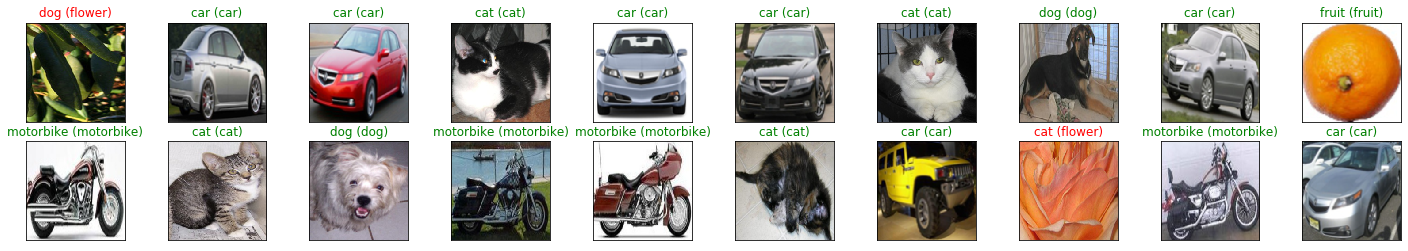

In [53]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

output = benchmark_model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

fig = plt.figure(figsize=(25, 4))
for pic in np.arange(20):
    ax = fig.add_subplot(2, 20/2, pic+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[pic], (1,2,0)))
    ax.set_title("{} ({})".format(classes[preds[pic]], classes[labels[pic]]),
                 color=("green" if preds[pic]==labels[pic].item() else "red"))